# Model Garbage Classification
Capstone Kampus Merdeka x Dicoding

[Source](https://www.kaggle.com/mostafaabla/garbage-classification)

# Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import PIL
import os, sys

# Set up datesets

In [4]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
local_zip = '/content/drive/MyDrive/Kaggle/datasets/garbage-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/Garbage Classification')
zip_ref.close()

# Check List Directory Datasets

In [6]:
## check current directory
os.getcwd()

'/content'

In [8]:
## check list directory datasets
listdir = os.listdir('/content/Garbage Classification/garbage_classification')
print('List Folder Image')
for i in range (0,len(listdir)):
  print(f'{i+1}. {listdir[i]}')

List Folder Image
1. white-glass
2. plastic
3. shoes
4. biological
5. clothes
6. paper
7. metal
8. trash
9. battery
10. cardboard
11. green-glass
12. brown-glass


# Check Image

In [9]:
# set up path
import pathlib
data_dir = pathlib.Path('/content/Garbage Classification/garbage_classification')

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total image from this datasets : {image_count}')

Total image from this datasets : 15515


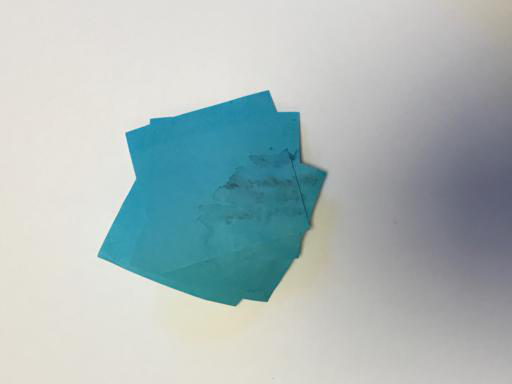

In [11]:
# paper directory
paper = list(data_dir.glob('paper/*'))
PIL.Image.open(str(paper[0]))

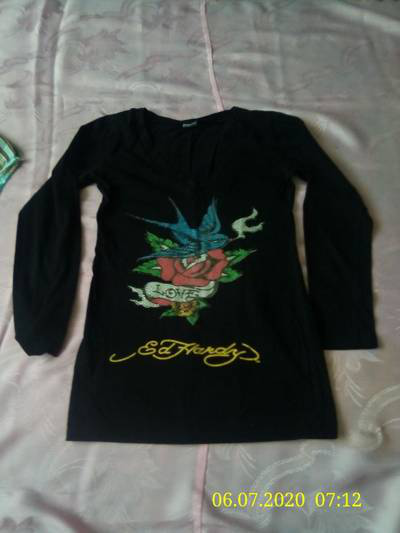

In [12]:
# clothes directory
clothes = list(data_dir.glob('clothes/*'))
PIL.Image.open(str(clothes[10]))

# Split data

In [13]:
# Parameter for spliting
batch_size = 32
img_height = 224
img_width = 224

In [14]:
# Train
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [16]:
class_names_val = val_ds.class_names
print(class_names_val)

['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


Check Image batch

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# Configure the dataset for performance

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Scaling Image

In [19]:
normalization_layer = layers.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Data Augmentation
generate random data

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# EarlyStoping Callbacks

In [27]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    patience =1, 
    verbose = 1, 
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001, 
    restore_best_weights = True)

callback = [early_stop]

# Create Model CNN

In [32]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
],name='layers_cnn')

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "layers_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 64)        1

In [35]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback,
  batch_size=16
)

Epoch 1/20
388/388 [==============================] - 25s 64ms/step - loss: 1.7315 - accuracy: 0.4424 - val_loss: 1.3958 - val_accuracy: 0.5253
Epoch 2/20
388/388 [==============================] - 24s 63ms/step - loss: 1.2216 - accuracy: 0.5907 - val_loss: 1.1544 - val_accuracy: 0.6101
Epoch 3/20
388/388 [==============================] - 24s 63ms/step - loss: 1.0425 - accuracy: 0.6548 - val_loss: 1.0559 - val_accuracy: 0.6468
Epoch 4/20
388/388 [==============================] - 24s 62ms/step - loss: 0.9297 - accuracy: 0.6898 - val_loss: 0.9843 - val_accuracy: 0.6848
Epoch 5/20
388/388 [==============================] - 24s 62ms/step - loss: 0.8435 - accuracy: 0.7245 - val_loss: 0.8974 - val_accuracy: 0.7045
Epoch 6/20
388/388 [==============================] - 24s 62ms/step - loss: 0.7717 - accuracy: 0.7461 - val_loss: 0.8949 - val_accuracy: 0.7071
Epoch 7/20
388/388 [==============================] - 24s 62ms/step - loss: 0.7060 - accuracy: 0.7675 - val_loss: 0.8363 - val_accuracy:

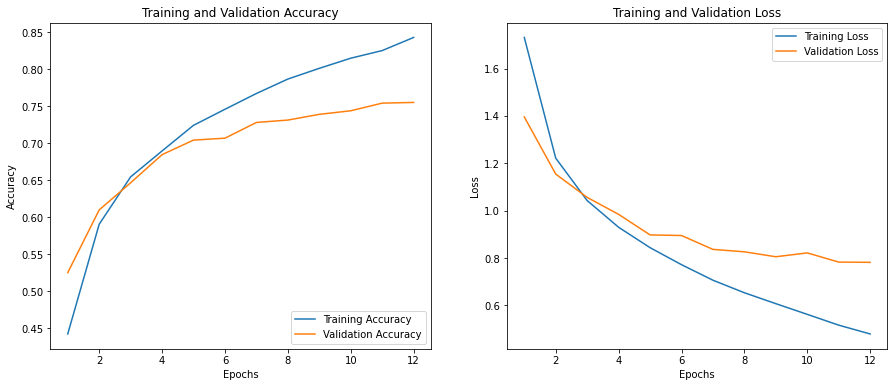

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.arange(1,13)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Import Model Into JSON

In [37]:
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 3.0 MB/s 


In [38]:
# convert into .h5
model.save("models.h5")

In [39]:
! tensorflowjs_converter --input_format=keras /content/models.h5 ./content/json/

In [42]:
# Zip file then download
from google.colab import files
! zip -r /content/model.zip /content/content
files.download('/content/model.zip')

updating: content/content/ (stored 0%)
updating: content/content/json/ (stored 0%)
updating: content/content/json/model.json (deflated 84%)
updating: content/content/json/group1-shard2of2.bin (deflated 8%)
updating: content/content/json/group1-shard1of2.bin (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>